In [ ]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm

# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# Upload zip file of patches directly to colab environment

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


In [ ]:
# ─── 1) CONFIG (Updated for Full Scan) ──────────────────────────────────
CONFIG = {
    'local_image_folder': extract_dir,  # read directly
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv",
    'h&e_model_meta_csv': "/content/drive/MyDrive/he_meta.csv",
    'h&e_model': "/content/drive/MyDrive/he_best_weights.pth",
    'melan_model_meta_csv': "/content/drive/MyDrive/melan_meta.csv",
    'melan_model': "/content/drive/MyDrive/melan_best_weights.pth",
    'sox10_model_meta_csv': "/content/drive/MyDrive/sox10_meta.csv",
    'sox10_model': "/content/drive/MyDrive/sox10_best_weights.pth",
    'num_workers': 4, # Number of workers for metadata scanning and DataLoader
    'batch_size': 16,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Example device
    'train_cases': [2,4,22,24,26,28,30,34,36,53,79,82,86,96,1,5,9,12,17,18,32,40,42,44,48,49,51,54,55,58,66,67,68,69,70,72,80,87,88,91,92,95,99,100,104,59,16],
    'test_cases': [23,27,45,46,78,85,14,15,19,38,50,65,83,84,97], #[34,1,99,62,89,2,12],
    'validation_cases':[21,25,43,56,93,94,3,7,11,47,57,64,73,75,98], #[12,90,21,3,85,25,98],
    'stains': ['h&e', 'melan', 'sox10']
}
# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stains for this run: {CONFIG['stains']}")

Cases included in initial full metadata scan: 77
Target stains for this run: ['h&e', 'melan', 'sox10']


In [ ]:
# ─── 2) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).

    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path)
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts.")

    return scan_dir(root)

In [ ]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")

🗺️  Created labels_map for 105 cases


In [ ]:
# ─── 4) WRAPPING MODELS AND DATA INTO LISTS ──────────────────────────────────────────────────────────────
stains = CONFIG['stains']
metadata = [pd.read_csv(CONFIG['h&e_model_meta_csv']), pd.read_csv(CONFIG['melan_model_meta_csv']), pd.read_csv(CONFIG['sox10_model_meta_csv'])]
models = [CONFIG['h&e_model'], CONFIG['melan_model'], CONFIG['sox10_model']]
train_meta = []
test_meta = []
for i,stain in enumerate(stains):
  train = metadata[i][metadata[i]['case_number'].isin(CONFIG['train_cases']+CONFIG['validation_cases'])]
  train = train.reset_index(drop=True)
  test = metadata[i][metadata[i]['case_number'].isin(CONFIG['test_cases'])]
  test = test.reset_index(drop=True)
  test = test[test['case_number'].astype(int).isin(labels_map.keys())].reset_index(drop=True)
  train_meta.append(train)
  test_meta.append(test)

In [ ]:
# ─── 5) CREATE TRANSFORMATIONS (Adjust based on model transforms) ──────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to whatever fixed size necessary
    transforms.RandomHorizontalFlip(p=0.5), #data augmentation with random flips
    transforms.ToTensor(), #converts PIL image to PyTorch tensor (needed for model training)
    # IMPORTANT: Normalize using ImageNet stats only if using a model pre-trained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to whatever fixed size necessary
    transforms.ToTensor(),#converts PIL image to PyTorch tensor (needed for model training)
    # IMPORTANT:Normalize using ImageNet stats only if using a model pre-trained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# ─── 6) CREATE PATCH DATASET CLASS ──────────────────────────────────────────────────────────────
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            cid = int(case_pat.search(os.path.basename(path)).group(1))
            return img, label, cid
        except Exception:
            return None

In [ ]:
# ─── 7) PRODUCE TRAIN AND TEST DATALOADERS ──────────────────────────────────────────────────────────────
train_loader = []
test_loader = []
for i, stain in enumerate(stains):
  train_loader.append(DataLoader(PatchDataset(train_meta[i], labels_map, transform=train_transform), batch_size=CONFIG['batch_size'], shuffle=True))
  test_loader.append(DataLoader(PatchDataset(test_meta[i], labels_map, transform=eval_transform), batch_size=CONFIG['batch_size'], shuffle=False))

In [ ]:
# ─── 8) DEFINE AND INITIATE YOUR MODEL HERE ──────────────────────────────────────────────────────────────
import torchvision.models as tv_models

class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True):
        super(KimiaNetClassifier, self).__init__()
        base = tv_models.densenet121(pretrained=False)
        if use_groupnorm:
            replace_bn_with_gn(base)
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

# ─── Helper: Replace BatchNorm with GroupNorm ───
def replace_bn_with_gn(module, num_groups=32):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            setattr(module, name, nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

device = CONFIG["device"]

In [ ]:
# ─── 9) COLLECT MODEL TRAIN AND TEST PREDICTIONS USING KIMIANET ──────────────────
from tqdm.notebook import tqdm
train_prob = []
test_prob = []

for i, stain in enumerate(tqdm(stains, desc="Stains")):
    stain_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True).to(device)

    # Load model weights
    state_dict = torch.load(models[i], map_location=device)
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
    stain_model.load_state_dict(filtered_state_dict, strict=False)
    stain_model.eval()

    all_probs_tr, all_probs_tst = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm(train_loader[i], desc=f"Train [{stain}]", leave=False):
            images = images.to(device)
            outputs = stain_model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, labels, _ in tqdm(test_loader[i], desc=f"Test [{stain}]", leave=False):
            images = images.to(device)
            outputs = stain_model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs_tst.extend(probs.cpu().numpy())
    train_prob.append([arr[0] for arr in all_probs_tr])
    test_prob.append([arr[0] for arr in all_probs_tst])

    #CHANGE HERE IF YOU HAVE CUSTOM THRESHOLDS FOR DIFFERENT MODELS
    #MELAN_THRESHOLD = 0.23
    #if stain == "melan":
        #train_prob.append([1 if arr[0] > MELAN_THRESHOLD else 0 for arr in all_probs_tr])
        #test_prob.append([1 if arr[0] > MELAN_THRESHOLD else 0 for arr in all_probs_tst])
    #else:


Stains:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train [h&e]:   0%|          | 0/1354 [00:00<?, ?it/s]

Test [h&e]:   0%|          | 0/476 [00:00<?, ?it/s]

Train [melan]:   0%|          | 0/841 [00:00<?, ?it/s]

Test [melan]:   0%|          | 0/261 [00:00<?, ?it/s]

Train [sox10]:   0%|          | 0/700 [00:00<?, ?it/s]

Test [sox10]:   0%|          | 0/214 [00:00<?, ?it/s]

In [ ]:
# EVALUATE MODEL
def evaluate_model_case_level_svc(df_train, df_test, train_prob, test_prob, stains, k, tune_svc=False, return_pred=False):
    # === Produce top k predicted probability dataframe for train data ===
    all_top_k = []
    print("📊 Aggregating top-k train probabilities...")
    for i, stain in enumerate(tqdm(stains, desc="Train Stains")):
        df_train_rs = df_train[i].reset_index(drop=True)
        stain_df = df_train_rs[df_train_rs['stain'] == stain]
        stain_prob = [train_prob[i][x] for x in stain_df.index]
        stain_top_k_prob = (
            pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob})
            .groupby('case_number', group_keys=False)[['case_number', 'prob']]
            .apply(lambda x: x.nlargest(k, columns='prob'))
            .reset_index(drop=True)
        )
        stain_top_k_prob['rank'] = stain_top_k_prob.groupby('case_number').cumcount()
        stain_top_k_prob = stain_top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
        stain_top_k_prob.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob.columns]
        all_top_k.append(stain_top_k_prob)

    top_k_prob = pd.concat(all_top_k, axis=1).dropna(axis=0)
    train_meta[0]['label'] = train_meta[0].case_number.map(labels_map)
    case_label = df_train[0][df_train[0].case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()

    # === Train the SVC ===
    print("🧠 Training classifier...")
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('✅ Selected parameters:', svc.best_params_)
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Produce top k predicted probability dataframe for test data ===
    all_top_k = []
    print("📊 Aggregating top-k test probabilities...")
    for i, stain in enumerate(tqdm(stains, desc="Test Stains")):
        df_test_rs = df_test[i].reset_index(drop=True).dropna()
        stain_df = df_test_rs[df_test_rs['stain'] == stain]
        stain_prob = [test_prob[i][x] for x in stain_df.index]
        stain_top_k_prob_tst = (
            pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob})
            .groupby('case_number', group_keys=False)[['case_number', 'prob']]
            .apply(lambda x: x.nlargest(k, columns='prob'))
            .reset_index(drop=True)
        )
        stain_top_k_prob_tst['rank'] = stain_top_k_prob_tst.groupby('case_number').cumcount()
        stain_top_k_prob_tst = stain_top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
        stain_top_k_prob_tst.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob_tst.columns]
        all_top_k.append(stain_top_k_prob_tst)

    top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna(axis=0)
    test_meta[0]['label'] = test_meta[0].case_number.map(labels_map)
    case_label_tst = df_test[0][df_test[0].case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

    # === Train metrics ===
    train_pred = svc.predict(top_k_prob)
    train_acc = accuracy_score(case_label, train_pred)
    train_rec = recall_score(case_label, train_pred)
    train_pre = precision_score(case_label, train_pred, zero_division=0)
    train_f1 = f1_score(case_label, train_pred, zero_division=0)
    print("\n📈 === Train Set Performance ===")
    print(f"Accuracy: {train_acc:.4f}")
    print(f"Precision: {train_pre:.4f}")
    print(f"Recall: {train_rec:.4f}")
    print(f"F1 Score: {train_f1:.4f}")

    # === Test metrics ===
    test_pred = svc.predict(top_k_prob_tst)
    test_acc = accuracy_score(case_label_tst, test_pred)
    test_rec = recall_score(case_label_tst, test_pred)
    test_pre = precision_score(case_label_tst, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_tst, test_pred, zero_division=0)
    print("\n📈 === Test Set Performance ===")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_pre:.4f}")
    print(f"Recall: {test_rec:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print("\n🧾 Classification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Confusion Matrix ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0, 1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0, 1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    return test_pred if return_pred else None

📊 Aggregating top-k train probabilities...


Train Stains:   0%|          | 0/3 [00:00<?, ?it/s]

🧠 Training classifier...
✅ Selected parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
📊 Aggregating top-k test probabilities...


Test Stains:   0%|          | 0/3 [00:00<?, ?it/s]


📈 === Train Set Performance ===
Accuracy: 0.8889
Precision: 0.8438
Recall: 1.0000
F1 Score: 0.9153

📈 === Test Set Performance ===
Accuracy: 0.7273
Precision: 0.7273
Recall: 1.0000
F1 Score: 0.8421

🧾 Classification Report:
                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         3
High-grade CMIL       0.73      1.00      0.84         8

       accuracy                           0.73        11
      macro avg       0.36      0.50      0.42        11
   weighted avg       0.53      0.73      0.61        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


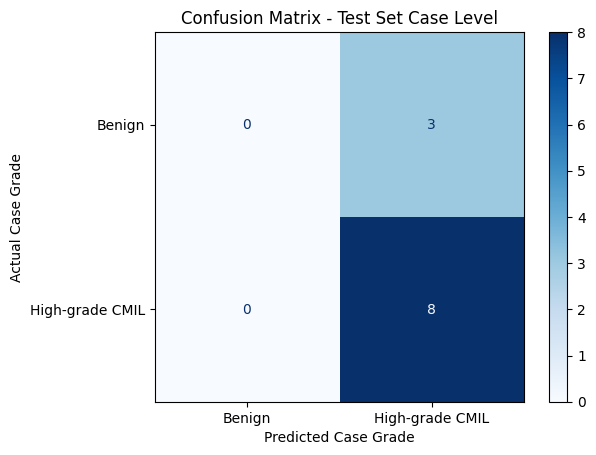

In [ ]:
evaluate_model_case_level_svc(train_meta, test_meta, train_prob, test_prob, stains, k=90, tune_svc=True)